# Trabalho 2 - Classificadores

## Código + Relatório

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

### 1. a) Regressão Logística – Gradiente Descendente

In [2]:
class LogisticRegression_GradientDescent():
    def __init__(self, learning_rate, epochs):
        self._estimator_type = "classifier"
        self.learning_rate_ = learning_rate
        self.epochs_ = epochs
    
    def calculate_gradient_descent(self, X, y):
        y_pred = self.predict(X[:, 1:])
        error = y - y_pred
        
        gradient = np.array([])
        for i in range(X.shape[1]):
            gradient = np.append(gradient, (self.learning_rate_ * np.sum((error * X[:, i]), axis=0) / X.shape[0]))
        
        return gradient
    
    #Atualizar os pesos 
    def update(self, X, y):
        gradient = self.calculate_gradient_descent(X, y)
        self.b = self.b + gradient

    def fit(self, X, y):
        ones = np.ones((X.shape[0], 1))
        X = np.hstack((ones, X))

        self.b = np.zeros(X.shape[1])

        for _ in range(self.epochs_):
            self.update(X, y)
        
    def predict(self, X):
        pred = np.array([])

        for x in X:
            res = self.b[0] + (1 / (1 + np.exp(-1 * (self.b[1:].T @ x))))
            pred = np.append(pred,  0 if res < 0.5 else 1)
    
        return pred

### 1. b) Naive Bayes Gaussiano 

In [3]:
class NaiveBayesGaussian():
    
    def __init__(self):
        self._estimator_type = "classifier"
        self.c_mean = {} # Objeto que armazena os vetores de medias para cada classe
        self.c_cov = []  # Matriz de covariancia
        self.y_prob = {} # Objeto que armazena a probabilidade de cada classe
        pass
    
    # Estima a probabilidade de cada classe ocorrer
    # Estima a matriz de covariancia
    # Estima a media de cada classe
    def fit(self, X, y):
        self.labels, y_counts =  np.unique(y, return_counts=True)#Definindo classes, quantidade de valores em cada classe
        n_samples, self.n_features = X.shape #Definindo numero de amostras, número de atributos
        self.c_cov = np.cov(X, rowvar=False) #Matriz de covariancia( sigma c)
        
        for label, y_count in zip(self.labels, y_counts):
            
            # p(c)
            self.y_prob[label] = (y_count / y_counts.sum()) # Calcula a probabilidade de determinada classe ocorrer
                                # y_count: a quantidade de amostras para cada classe.(ex: 20 amostras para classe 1)
                                # y_counts: contem todos as amostras de todas as classes juntas.(ex: 100 amostras no geral, considerando todas as amostras de todas as classes)    
            
            #[0,2]             [1]  [1,2,1,3]                                        
            indices = np.where(y == label) # indices em que determinada classe ocorre
            
            # Atributos que resultaram em determinada classe(xi)
            x = np.array([X[index, :] for index in indices]).reshape(y_count,self.n_features) 
            
            #Media calculada para determinada classe(mi c)
            self.c_mean[label] = x.mean(axis=0) 
        
        return self
    
    # Prediz o valor de y com base do x
    def predict(self, X):
        predict = np.array([])
        n_samples = X.shape[0] #Número de amostras
        
        #calcula P(C|x) para cada x em X
        for x in X:
            pred = np.array([])
            for label in self.labels:
                                
                #calcula a formula P(X|C)
                aux = 1 / (np.power(2*np.pi, self.n_features / 2) * np.sqrt(np.linalg.det(self.c_cov)))
                prob_x_c = aux * np.exp(-(1.0/2) * (x - self.c_mean[label]).T @ np.linalg.inv(self.c_cov)@(x - self.c_mean[label]))
                pred = np.append(pred, prob_x_c * self.y_prob[label]) # Salva P(X|C) * P(C) para cada classe C    
                
            y_pred = self.labels[np.where(pred == pred.max())] # Obtem a classe com maior probabilidade
            
            predict = np.append(predict, y_pred)
                            
        return predict    

### 1. c) Discriminante Quadrático Gaussiano 

In [4]:
class QuadraticDiscriminantGaussian():
    
    def __init__(self):
        self._estimator_type = "classifier"
        self.c_mean = {} #Objeto que armazena os vetores de medias para cada classe 
        self.c_cov = {} #Objeto que armazena as matrizes de covariância para cada classe
        self.y_prob = {} #Objeto que armazena a probabilidade de cada classe
        pass 
    
    def fit(self, X, y):
        self.labels, y_counts = np.unique(y, return_counts=True) #Definindo classes e quantidade de valores em cada classe 
        n_samples, self.n_features = X.shape #Definindo número de amostras e número de atribututos
        
        for label, y_count in zip(self.labels, y_counts):
            
            self.y_prob[label] = (y_count / y_counts.sum()) #Calculo da probabilidade de cada classe
            indices = np.where(y == label) #Indices em que determinada classe ocorre 
            x = np.array([X[index, :] for index in indices]).reshape(y_count, self.n_features) #Atributos que resultam em determinada classe 
            self.c_mean[label] = x.mean(axis=0) #Media calculada para determinada classe 
            self.c_cov[label] = np.cov(x, rowvar=False) #Matriz de covariancia de cada classe
                
        return self
    
    def predict(self, X):
        predict = np.array([])
        n_samples = X.shape[0] #Número de amostras
        
        #Calcula P(C/x) para cada x em X 
        for x in X:
            pred = np.array([])
            for label in self.labels:
                #Calcula a formula P(X/C)
                aux = 1 / (np.power(2*np.pi, self.n_features / 2) * np.sqrt(np.linalg.det(self.c_cov[label])))
                prob_x_c = aux * np.exp(-(1.0/2) * (x - self.c_mean[label]).T @ np.linalg.inv(self.c_cov[label]) @ (x - self.c_mean[label]))
                
                pred = np.append(pred, prob_x_c * self.y_prob[label]) # Salva P(X/C) * P(C) para cada classe C
            
            y_pred = self.labels[np.where(pred == pred.max())] # Obtem a classe com maior probabilidade
            predict = np.append(predict, y_pred)
        
        return predict   

### 2. Função Acurácia (retorna a porcentagem de acerto)

In [5]:
def acuracia(y_true, y_pred):
    count = 0;
    for t, p in zip(y_true, y_pred):
        if t == p:
            count += 1
    return (count / y_true.shape[0])

### 3. Matriz de confusão

In [6]:
def plot_confusion_matrix_(X, y, clf):
    conf = plot_confusion_matrix(clf, X, y)
    conf.ax_.set_title("Matriz de confusão")
    plt.show()

### 4. Gráfico de dispersão

In [7]:
def plot_boundaries(X, y, clf):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
 #  h = .02  
    h = .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(4, 3))
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
    
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

    plt.show()

### Carregando e dividindo o conjunto de dados 

In [8]:
data = np.loadtxt("./data_trab2/ex2data1.txt", delimiter=",")

X = data[:,:-1]
y = data[:, -1]

# Dividindo e embaralhando os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3)

## Relatório

### Questão 1

### Aplicando Regressão Logística – Gradiente Descendente

In [9]:
LR_GD = LogisticRegression_GradientDescent(epochs=200, learning_rate=0.00001)
LR_GD.fit(X_train, y_train)
y_test_pred_LR_GD = LR_GD.predict(X_test)
print('Acurácia: ', acuracia(y_test, y_test_pred_LR_GD))

Acurácia:  0.6333333333333333


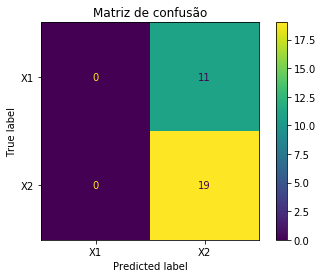

In [10]:
# Matriz de confusão

LR_GD.classes_ =  ["X1","X2"]
plot_confusion_matrix_(X_test, y_test, LR_GD)

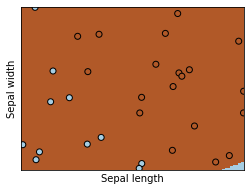

In [11]:
# Gráfico de dispersão 

plot_boundaries(X_test, y_test, LR_GD)

### Aplicando Naive Bayes Gaussiano

In [12]:
NBG = NaiveBayesGaussian()
NBG.fit(X_train, y_train)
y_test_pred_NBG = NBG.predict(X_test)
print('Acurácia: ', acuracia(y_test, y_test_pred_NBG))

Acurácia:  0.9666666666666667


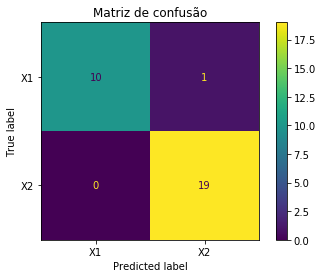

In [13]:
# Matriz de confusão

NBG.classes_ =  ["X1","X2"]
plot_confusion_matrix_(X_test, y_test, NBG)

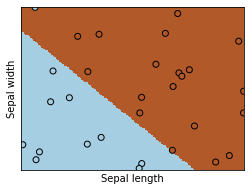

In [14]:
# Gráfico de dispersão 

plot_boundaries(X_test, y_test, NBG)

### Aplicando Discriminante Quadrático Gaussiano 

In [15]:
QDG = QuadraticDiscriminantGaussian()
QDG.fit(X_train, y_train)
y_test_pred_QDG = QDG.predict(X_test)
print('Acurácia: ', acuracia(y_test, y_test_pred_QDG))

Acurácia:  0.9333333333333333


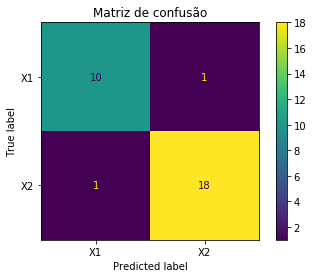

In [16]:
# Matriz de confusão

QDG.classes_ =  ["X1","X2"]
plot_confusion_matrix_(X_test, y_test, QDG)

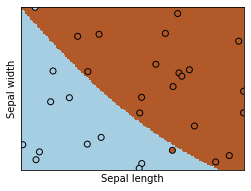

In [17]:
# Gráfico de dispersão 

plot_boundaries(X_test, y_test, QDG)

## 2. O dado parece se linearmente separável ou não?

### Sim, apesar de existirem alguns pontos outliers, o dado parece ser linearmente separável.

## 3. Quais dos métodos produziu fronteiras lineares?

### Todos os três métodos, apesar da Regressão Logística não tenha tido uma fronteira linear que separou bem os dados.

## 4. Qual teve melhor acurácia?

### O Naive Bayes Gaussiano.